# 📊 TKM Data Science Pipeline (High-Quality Standard)

Notebook ini mengimplementasikan **siklus data science standar** untuk analisis Tingkat Kegemaran Membaca (TKM).  
Struktur pipeline:  

1. **Config & Imports**  
2. **Load Data**  
3. **Data Cleaning & Validation**  
4. **Feature Engineering (Sub-Indeks Pra, Saat, Pasca Membaca)**  
5. **Composite Scoring (Indeks TKM)**  
6. **Aggregation (Kabupaten/Kota, Provinsi)**  
7. **Normalization & Categorization**  
8. **Visualization (Distribusi, Ranking, Peta)**  
9. **Reporting (Excel multi-sheet, JSON Config, PNG plots)**  

---


In [1]:
# %% [code]
# === Imports ===
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from datetime import datetime

try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except:
    PLOTLY_AVAILABLE = False

print("✅ Environment ready")

✅ Environment ready


In [2]:
# %% [code]
# === Config ===

DATA_PATH = "/content/TKM_2_edit.xlsx"   # <- isi path file Excel/CSV Anda
OUTPUT_DIR = "./outputs_tkm"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

PROV_COL = "A5"
KABKOT_COL = "A6"

PREFIX_GROUPS = {"B": "pra", "C": "saat", "D": "pasca"}
WEIGHTS = {"pra": 0.15, "saat": 0.50, "pasca": 0.35}

LIKERT_MIN, LIKERT_MAX = 1, 4
MIN_FRAC_AVAILABLE_PER_SUBINDEX = 0.5
AGG_NORM_METHOD = "minmax"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# save config
cfg = dict(
    DATA_PATH=DATA_PATH, OUTPUT_DIR=OUTPUT_DIR,
    PROV_COL=PROV_COL, KABKOT_COL=KABKOT_COL,
    PREFIX_GROUPS=PREFIX_GROUPS, WEIGHTS=WEIGHTS,
    LIKERT_MIN=LIKERT_MIN, LIKERT_MAX=LIKERT_MAX,
    MIN_FRAC_AVAILABLE_PER_SUBINDEX=MIN_FRAC_AVAILABLE_PER_SUBINDEX,
    AGG_NORM_METHOD=AGG_NORM_METHOD, RANDOM_SEED=RANDOM_SEED,
    generated_at=datetime.now().isoformat()
)
with open(Path(OUTPUT_DIR, "config.json"), "w", encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)

print("Config saved ->", Path(OUTPUT_DIR, "config.json"))

Config saved -> outputs_tkm/config.json


In [3]:
# %% [code]
# === Utility Functions ===
from typing import Dict, List

def ensure_numeric(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def scale_0_1(x: pd.Series, vmin: float, vmax: float) -> pd.Series:
    return (x - vmin) / (vmax - vmin) if vmax > vmin else np.nan

def mean_if_enough(series: pd.Series, min_frac: float) -> float:
    non_na = series.dropna()
    return non_na.mean() if len(non_na)/len(series) >= min_frac else np.nan

def compute_subindex_means(df: pd.DataFrame, group_cols: Dict[str, List[str]]) -> pd.DataFrame:
    out = df.copy()
    for key, cols in group_cols.items():
        if not cols:
            out[f"subidx_{key}_0_1"] = np.nan
            continue
        tmp = ensure_numeric(out, cols)
        scaled = tmp[cols].apply(lambda c: scale_0_1(c, LIKERT_MIN, LIKERT_MAX))
        out[f"subidx_{key}_0_1"] = scaled.apply(lambda r: mean_if_enough(r, MIN_FRAC_AVAILABLE_PER_SUBINDEX), axis=1)
    return out

def compute_composite(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    comp = sum(out[f"subidx_{k}_0_1"] * w for k, w in WEIGHTS.items())
    out["index_0_1"] = comp / sum(WEIGHTS.values())
    out["index_0_100"] = out["index_0_1"] * 100
    return out

def aggregate_kabkot(df: pd.DataFrame) -> pd.DataFrame:
    return (df.groupby([PROV_COL, KABKOT_COL], dropna=False)
              .agg(index_0_1_mean=("index_0_1","mean"),
                   index_0_100_mean=("index_0_100","mean"),
                   n_responden=(KABKOT_COL,"size"))
              .reset_index())

def normalize_agg(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    x = out["index_0_1_mean"]
    if AGG_NORM_METHOD == "zscore_cdf":
        out["kab_norm_0_1"] = stats.norm.cdf((x-x.mean())/x.std(ddof=0))
    else:
        out["kab_norm_0_1"] = (x - x.min())/(x.max()-x.min()) if x.max()>x.min() else 0
    q = out["kab_norm_0_1"].quantile([0.25,0.5,0.75]).to_dict()
    def cat(v):
        if v<=q[0.25]: return "Rendah"
        if v<=q[0.5]: return "Menengah-Rendah"
        if v<=q[0.75]: return "Menengah-Tinggi"
        return "Tinggi"
    out["kategori"] = out["kab_norm_0_1"].apply(cat)
    return out

def plot_distribution(data, title, path=None):
    plt.figure(figsize=(10,6))
    sns.histplot(data.dropna(), kde=True)
    q1,q2,q3 = data.quantile([0.25,0.5,0.75])
    for qv,lab in [(q1,"Q1"),(q2,"Median"),(q3,"Q3")]:
        plt.axvline(qv, linestyle="--")
        plt.text(qv, plt.ylim()[1]*0.9, lab, rotation=90)
    plt.title(title)
    if path: plt.savefig(path,dpi=150)
    plt.show()

In [4]:
# %% [code]
# === Load Data ===
if not DATA_PATH:
    raise ValueError("⚠️ DATA_PATH kosong, isi path file Anda")

DATA_PATH = Path(DATA_PATH)
if DATA_PATH.suffix.lower() in [".xlsx",".xls"]:
    df = pd.read_excel(DATA_PATH)
elif DATA_PATH.suffix.lower()==".csv":
    df = pd.read_csv(DATA_PATH)
else:
    raise ValueError("Format file tidak didukung")

print("Shape:", df.shape)
print(df.head())

Shape: (14151, 83)
             TIMESTAMP                        EMAIL KONFIRMASI             A1  \
0  19/08/2025 18:47:20       ainunrizki30@gmail.com   BERSEDIA  18 - 24 Tahun   
1  19/08/2025 16:06:10   sitiauliamagfira@gmail.com   BERSEDIA  25 - 39 Tahun   
2  19/08/2025 16:13:57      auliansyah141@gmail.com   BERSEDIA  25 - 39 Tahun   
3  19/08/2025 16:44:17  kampunghalaman151@gmail.com   BERSEDIA  25 - 39 Tahun   
4  19/08/2025 16:59:14    alviancaniago07@gmail.com   BERSEDIA  25 - 39 Tahun   

          A2             A3                                     A4  \
0  Perempuan     SMA/SMK/MA                              Mahasiswa   
1  Perempuan  Sarjana-D4/S1                        Pegawai Honorer   
2  Laki-Laki  Sarjana-D4/S1                        Pegawai Honorer   
3  Laki-Laki  Sarjana-D4/S1  Profesi lainnya yang belum disebutkan   
4  Laki-Laki  Sarjana-D4/S1                        Pegawai Honorer   

              A5                 A6  B1  ...  E7  E8  E9  E10  E11  E12  

In [5]:
# %% [code]
# === Prepare Groups & Compute Index ===
group_cols = {v:[c for c in df.columns if c.startswith(k)] for k,v in PREFIX_GROUPS.items()}
df_idx = compute_subindex_means(df, group_cols)
df_idx = compute_composite(df_idx)
df_idx[[PROV_COL,KABKOT_COL,"index_0_100"]].head()

,A5,A6,index_0_100
0,PROVINSI ACEH,KAB. BENER MERIAH,57.479167
1,PROVINSI ACEH,KAB. SIMEULUE,65.729167
2,PROVINSI ACEH,KAB. SIMEULUE,98.833333
3,PROVINSI ACEH,KAB. SIMEULUE,98.958333
4,PROVINSI ACEH,KAB. SIMEULUE,81.458333


In [6]:
# %% [code]
# === Aggregate & Normalize ===
kab = aggregate_kabkot(df_idx)
kab_norm = normalize_agg(kab)
prov = kab_norm.groupby(PROV_COL).agg(index_0_100_mean=("index_0_100_mean","mean"), n=("n_responden","sum")).reset_index()
kab_norm.head()

# Tampilkan semua hasil agregasi
pd.set_option("display.max_rows", None)  # hilangkan batas jumlah baris
display(kab_norm)


,A5,A6,index_0_1_mean,index_0_100_mean,n_responden,kab_norm_0_1,kategori
0,PROVINSI ACEH,KAB. BENER MERIAH,0.574792,57.479167,1,0.417062,Rendah
1,PROVINSI ACEH,KAB. SIMEULUE,0.765742,76.574219,32,0.680783,Tinggi
2,PROVINSI ACEH,KOTA SUBULUSSALAM,0.784557,78.455729,4,0.706769,Tinggi
3,PROVINSI BALI,KAB. BADUNG,0.664479,66.447917,1,0.540929,Menengah-Rendah
4,PROVINSI BALI,KAB. BULELENG,0.630174,63.017361,3,0.493550,Rendah
5,PROVINSI BALI,KAB. GIANYAR,0.779597,77.959722,15,0.699918,Tinggi
6,PROVINSI BALI,KAB. JEMBRANA,0.748750,74.875000,1,0.657315,Menengah-Tinggi
7,PROVINSI BALI,KOTA DENPASAR,0.704896,70.489583,2,0.596749,Menengah-Tinggi
8,PROVINSI BANTEN,KAB. PANDEGLANG,0.643854,64.385417,2,0.512444,Menengah-Rendah
9,PROVINSI BANTEN,KAB. SERANG,0.747604,74.760417,1,0.655733,Menengah-Tinggi


,A5,A6,index_0_1_mean,index_0_100_mean,index_0_100_label,n_responden,kategori_abs
0,PROVINSI ACEH,KAB. BENER MERIAH,0.574792,57.479167,57.48 (Rendah),1,Rendah
1,PROVINSI ACEH,KAB. SIMEULUE,0.765742,76.574219,76.57 (Menengah-Tinggi),32,Menengah-Tinggi
2,PROVINSI ACEH,KOTA SUBULUSSALAM,0.784557,78.455729,78.46 (Menengah-Tinggi),4,Menengah-Tinggi
3,PROVINSI BALI,KAB. BADUNG,0.664479,66.447917,66.45 (Menengah-Rendah),1,Menengah-Rendah
4,PROVINSI BALI,KAB. BULELENG,0.630174,63.017361,63.02 (Menengah-Rendah),3,Menengah-Rendah
5,PROVINSI BALI,KAB. GIANYAR,0.779597,77.959722,77.96 (Menengah-Tinggi),15,Menengah-Tinggi
6,PROVINSI BALI,KAB. JEMBRANA,0.748750,74.875000,74.87 (Menengah-Tinggi),1,Menengah-Tinggi
7,PROVINSI BALI,KOTA DENPASAR,0.704896,70.489583,70.49 (Menengah-Tinggi),2,Menengah-Tinggi
8,PROVINSI BANTEN,KAB. PANDEGLANG,0.643854,64.385417,64.39 (Menengah-Rendah),2,Menengah-Rendah
9,PROVINSI BANTEN,KAB. SERANG,0.747604,74.760417,74.76 (Menengah-Tinggi),1,Menengah-Tinggi


/tmp/ipython-input-2708048704.py:40: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  df_idx.to_excel(w, "responden", index=False)
/tmp/ipython-input-2708048704.py:41: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  kab_norm[cols_show].to_excel(w, "kabkot", index=False)
/tmp/ipython-input-2708048704.py:42: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  prov.to_excel(w, "provinsi", index=False)


✅ File Excel tersimpan: outputs_tkm/TKM_outputs_abs.xlsx


✅ Grafik bar interaktif tersimpan: outputs_tkm/bar_index100_kabkot_interaktif.html


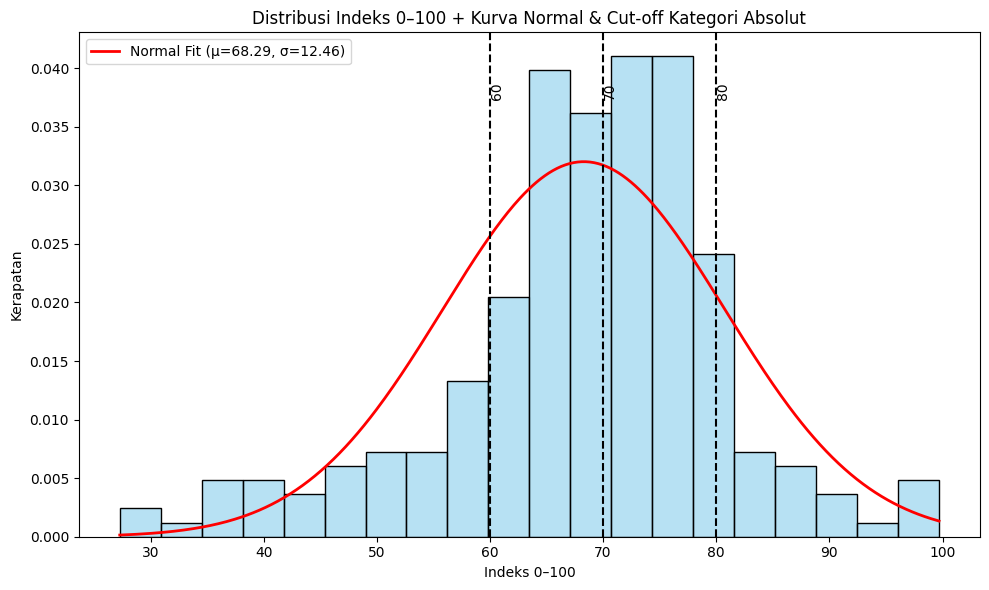

✅ Histogram + kurva normal tersimpan: outputs_tkm/dist_index100_abs.png


In [7]:
# %% [code]
# === Kategori Absolut & Visualisasi Lengkap ===

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px

# 1. Definisi fungsi kategori absolut
def categorize_absolute(score: float) -> str:
    if score < 60:
        return "Rendah"
    elif score < 70:
        return "Menengah-Rendah"
    elif score < 80:
        return "Menengah-Tinggi"
    else:
        return "Tinggi"

# 2. Tambahkan kategori & label gabungan
kab_norm["kategori_abs"] = kab_norm["index_0_100_mean"].apply(categorize_absolute)
kab_norm["index_0_100_label"] = kab_norm["index_0_100_mean"].apply(
    lambda v: f"{v:.2f} ({categorize_absolute(v)})"
)

# 3. Hapus kolom norm index (jika ada)
kab_norm = kab_norm.drop(columns=["kab_norm_0_1"], errors="ignore")

# 4. Tampilkan hasil
cols_show = [PROV_COL, KABKOT_COL, "index_0_1_mean", "index_0_100_mean",
             "index_0_100_label", "n_responden", "kategori_abs"]
pd.set_option("display.max_rows", None)
display(kab_norm[cols_show])

# 5. Simpan ke Excel multi-sheet
excel_path = Path(OUTPUT_DIR, "TKM_outputs_abs.xlsx")
with pd.ExcelWriter(excel_path, engine="openpyxl") as w:
    df_idx.to_excel(w, "responden", index=False)
    kab_norm[cols_show].to_excel(w, "kabkot", index=False)
    prov.to_excel(w, "provinsi", index=False)
print("✅ File Excel tersimpan:", excel_path)

# 6. Bar chart interaktif per Kab/Kota
kab_sorted = kab_norm.sort_values("index_0_100_mean", ascending=True)
fig = px.bar(
    kab_sorted,
    x="index_0_100_mean",
    y=KABKOT_COL,
    orientation="h",
    color="kategori_abs",
    hover_data={
        PROV_COL: True,
        KABKOT_COL: True,
        "index_0_100_mean": ":.2f",
        "index_0_100_label": True,
        "n_responden": True,
        "kategori_abs": True
    },
    title="Indeks 0–100 per Kab/Kota (Kategori Absolut)",
)
# Garis cut-off
for c, lab in [(60,"60"),(70,"70"),(80,"80")]:
    fig.add_vline(x=c, line_dash="dash", annotation_text=lab, annotation_position="top")

fig.update_layout(
    xaxis_title="Indeks 0–100",
    yaxis_title="Kabupaten/Kota",
    yaxis=dict(categoryorder="total ascending"),
    height=max(600, 20*len(kab_sorted))  # auto tinggi agar label kab/kota terbaca
)

out_html = Path(OUTPUT_DIR, "bar_index100_kabkot_interaktif.html")
fig.write_html(out_html, include_plotlyjs="cdn")
fig.show()
print("✅ Grafik bar interaktif tersimpan:", out_html)

# 7. Histogram + kurva normal
x = kab_norm["index_0_100_mean"].dropna()
mu, sigma = x.mean(), x.std(ddof=0)
xs = np.linspace(x.min(), x.max(), 400)
pdf = stats.norm.pdf(xs, mu, sigma)

plt.figure(figsize=(10,6))
sns.histplot(x, kde=False, bins=20, stat="density", color="skyblue", alpha=0.6)
plt.plot(xs, pdf, 'r-', linewidth=2, label=f"Normal Fit (μ={mu:.2f}, σ={sigma:.2f})")

for cutoff, label in [(60, "60"), (70, "70"), (80, "80")]:
    plt.axvline(cutoff, linestyle="--", color="black")
    plt.text(cutoff, plt.ylim()[1]*0.9, label, rotation=90, va="top")

plt.title("Distribusi Indeks 0–100 + Kurva Normal & Cut-off Kategori Absolut")
plt.xlabel("Indeks 0–100")
plt.ylabel("Kerapatan")
plt.legend()
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR, "dist_index100_abs.png"), dpi=150)
plt.show()
print("✅ Histogram + kurva normal tersimpan:", Path(OUTPUT_DIR, "dist_index100_abs.png"))


✅ Data dengan kategori absolut tersimpan di: outputs_tkm/kabkot_full_abs.xlsx


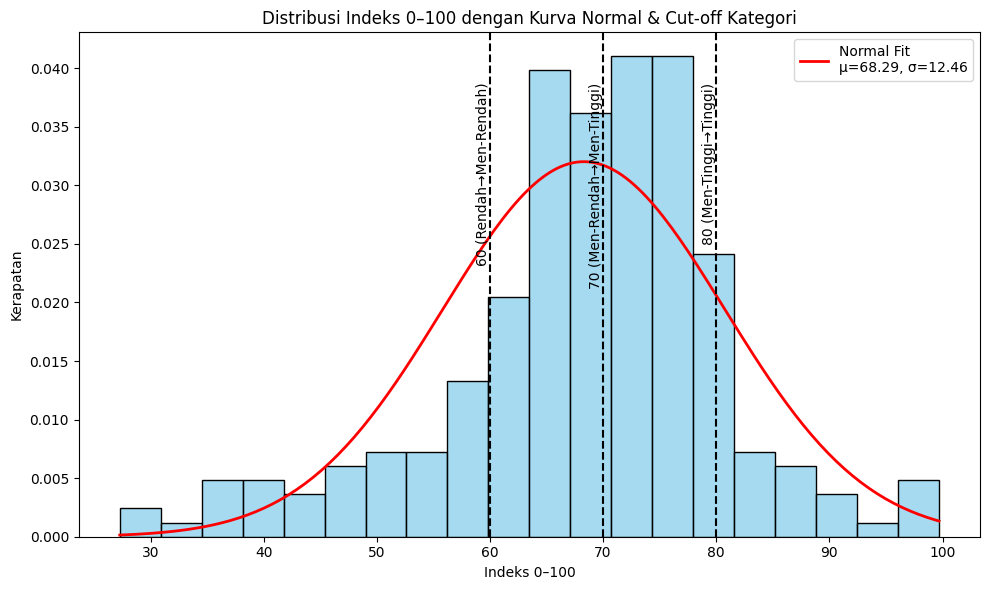

In [8]:
# %% [code]
# === Kategori Absolut Berdasarkan Skor 0-100 ===

def categorize_absolute(score):
    if score < 60:
        return "Rendah"
    elif score < 70:
        return "Menengah-Rendah"
    elif score < 80:
        return "Menengah-Tinggi"
    else:
        return "Tinggi"

kab_norm["kategori_abs"] = kab_norm["index_0_100_mean"].apply(categorize_absolute)

# Simpan hasil dengan kategori absolut
kab_norm.to_excel(Path(OUTPUT_DIR, "kabkot_full_abs.xlsx"), index=False)
print("✅ Data dengan kategori absolut tersimpan di:", Path(OUTPUT_DIR,"kabkot_full_abs.xlsx"))

# === Visualisasi Distribusi Normal (Index 0–100) ===
plt.figure(figsize=(10,6))
sns.histplot(kab_norm["index_0_100_mean"].dropna(), kde=False, bins=20, color="skyblue", stat="density")

# Hitung mean dan std
mu, sigma = kab_norm["index_0_100_mean"].mean(), kab_norm["index_0_100_mean"].std(ddof=0)
xs = np.linspace(kab_norm["index_0_100_mean"].min(), kab_norm["index_0_100_mean"].max(), 200)
pdf = stats.norm.pdf(xs, mu, sigma)

# Plot kurva normal
plt.plot(xs, pdf, 'r-', lw=2, label=f'Normal Fit\nμ={mu:.2f}, σ={sigma:.2f}')

# Tambahkan garis cut-off kategori
for cutoff, label in [(60, "60 (Rendah→Men-Rendah)"),
                      (70, "70 (Men-Rendah→Men-Tinggi)"),
                      (80, "80 (Men-Tinggi→Tinggi)")]:
    plt.axvline(cutoff, linestyle="--", color="black")
    plt.text(cutoff, plt.ylim()[1]*0.9, label, rotation=90, va="top", ha="right")

plt.title("Distribusi Indeks 0–100 dengan Kurva Normal & Cut-off Kategori")
plt.xlabel("Indeks 0–100")
plt.ylabel("Kerapatan")
plt.legend()
plt.tight_layout()
plt.savefig(Path(OUTPUT_DIR,"dist_index100_abs.png"), dpi=150)
plt.show()


In [9]:
# %% [code]
# === Distribusi Indeks 0–100 (INTERAKTIF) + Kategori Absolut ===
# Pastikan sudah ada kolom `kategori_abs` seperti yang Anda buat sebelumnya.

try:
    import plotly.express as px
    import plotly.graph_objects as go
    from pathlib import Path
    import numpy as np
    from scipy import stats

    x = kab_norm["index_0_100_mean"].dropna()

    # Statistik untuk normal-fit
    mu, sigma = x.mean(), x.std(ddof=0)
    xs = np.linspace(x.min(), x.max(), 400)
    pdf = stats.norm.pdf(xs, mu, sigma)

    # Histogram interaktif (density)
    fig = px.histogram(
        kab_norm,
        x="index_0_100_mean",
        nbins=20,
        histnorm="probability density",
        opacity=0.6,
        title="Distribusi Indeks 0–100 (Interaktif) + Kurva Normal & Cut-off Kategori",
    )

    # Kurva normal
    fig.add_trace(
        go.Scatter(
            x=xs,
            y=pdf,
            mode="lines",
            name=f"Normal Fit (μ={mu:.2f}, σ={sigma:.2f})",
        )
    )

    # Garis cut-off kategori + titik hover dengan label
    cutoffs = [(60, "60 (Rendah→Men-Rendah)"),
               (70, "70 (Men-Rendah→Men-Tinggi)"),
               (80, "80 (Men-Tinggi→Tinggi)")]

    for c, lab in cutoffs:
        # garis vertikal
        fig.add_vline(x=c, line_dash="dash")
        # titik hover tak terlihat (untuk label interaktif)
        fig.add_trace(
            go.Scatter(
                x=[c], y=[max(pdf)*0.95],
                mode="markers+text",
                text=[lab],
                textposition="top right",
                marker=dict(size=8, opacity=0),
                showlegend=False,
                hovertemplate=f"<b>{lab}</b><extra></extra>",
            )
        )

    # Tambahkan titik hover untuk Mean & Std (opsional)
    fig.add_trace(
        go.Scatter(
            x=[mu], y=[stats.norm.pdf(mu, mu, sigma)],
            mode="markers+text",
            text=[f"Mean μ={mu:.2f}"],
            textposition="bottom right",
            marker=dict(size=10, opacity=0),
            showlegend=False,
            hovertemplate=f"<b>Mean μ={mu:.2f}</b><extra></extra>",
        )
    )

    # Hover template histogram
    fig.update_traces(
        selector=dict(type="histogram"),
        hovertemplate="Index: %{x:.2f}<br>Density: %{y:.4f}<extra></extra>",
    )

    fig.update_layout(
        xaxis_title="Indeks 0–100",
        yaxis_title="Kerapatan",
        bargap=0.05,
    )

    # Simpan sebagai HTML interaktif
    out_html = Path(OUTPUT_DIR, "dist_index100_abs_interaktif.html")
    fig.write_html(out_html, include_plotlyjs="cdn")
    fig.show()
    print("✅ Grafik interaktif tersimpan:", out_html)

except Exception as e:
    print("Plotly tidak tersedia, fallback ke Matplotlib.")
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10,6))
    sns.histplot(x, kde=False, bins=20, stat="density")

    xs = np.linspace(x.min(), x.max(), 400)
    pdf = stats.norm.pdf(xs, x.mean(), x.std(ddof=0))
    plt.plot(xs, pdf, linewidth=2)

    for c, lab in [(60,"60"), (70,"70"), (80,"80")]:
        plt.axvline(c, linestyle="--")
        plt.text(c, plt.ylim()[1]*0.9, lab, rotation=90, va="top")

    plt.title("Distribusi Indeks 0–100 dengan Kurva Normal & Cut-off Kategori (Static)")
    plt.xlabel("Indeks 0–100")
    plt.ylabel("Kerapatan")
    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR,"dist_index100_abs.png"), dpi=150)
    plt.show()
    print("✅ Grafik statik tersimpan:", Path(OUTPUT_DIR,"dist_index100_abs.png"))


✅ Grafik interaktif tersimpan: outputs_tkm/dist_index100_abs_interaktif.html


In [10]:
# %% [code]
# === Visualisasi Indeks 0–100 per Kab/Kota (Interaktif dengan Label) ===

# Urutkan kabupaten/kota dari terendah ke tertinggi
kab_sorted = kab_norm.sort_values("index_0_100_mean", ascending=True)

# Bar chart interaktif dengan label kab/kota
fig = px.bar(
    kab_sorted,
    x="index_0_100_mean",
    y=KABKOT_COL,
    orientation="h",
    color="kategori_abs",  # warnai berdasarkan kategori absolut
    hover_data=[PROV_COL, "index_0_100_mean", "kategori_abs"],
    title="Indeks 0–100 per Kabupaten/Kota (dengan Kategori Absolut)",
)

# Tambahkan garis cut-off kategori
for c, lab in [(60, "60"), (70, "70"), (80, "80")]:
    fig.add_vline(x=c, line_dash="dash", annotation_text=lab, annotation_position="top")

fig.update_layout(
    xaxis_title="Indeks 0–100",
    yaxis_title="Kabupaten/Kota",
    height=1000,  # tinggi supaya semua label kebaca
    yaxis=dict(categoryorder="total ascending"),
)

# Simpan ke HTML interaktif
out_html = Path(OUTPUT_DIR, "bar_index100_kabkot_interaktif.html")
fig.write_html(out_html, include_plotlyjs="cdn")
fig.show()
print("✅ Grafik bar interaktif tersimpan:", out_html)


✅ Grafik bar interaktif tersimpan: outputs_tkm/bar_index100_kabkot_interaktif.html


In [11]:
!pip install xlsxwriter

# %% [code]
# === Reporting ===
excel_path = Path(OUTPUT_DIR,"TKM_outputs.xlsx")
with pd.ExcelWriter(excel_path,engine="xlsxwriter") as w:
    df_idx.to_excel(w,"responden",index=False)
    kab_norm.to_excel(w,"kabkot",index=False)
    prov.to_excel(w,"provinsi",index=False)
print("Saved ->", excel_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.2 MB/s eta 0:00:00


/tmp/ipython-input-899581055.py:7: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

/tmp/ipython-input-899581055.py:8: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

/tmp/ipython-input-899581055.py:9: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.



Saved -> outputs_tkm/TKM_outputs.xlsx
